In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
from time import time, strptime, mktime
torch.manual_seed(0)
np.random.seed(0)

In [6]:
root = '403781'

In [76]:
def collect(byf, fname, verbose=True):
    res = []
    li = 0
    added = 0
    with open('/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-30.txt') as fl:
        _ = fl.readline()
        line = fl.readline()
        while line:
            if 'NULL' not in line:
                obj = byf(line)
                if obj is not None:
                    res.append(obj)
                    added += 1
            line = fl.readline()
            li += 1
            if li % 10000 == 0 and verbose:
                sys.stdout.write('%d       \r' % li)
        if verbose: sys.stdout.flush()
    if verbose: print('Collected %d/%d' % (added, li))
    return res

def by(line):
    if root in line:
        try:
            fobj = fmt(line)
            bus_id = fobj['routeid'].split('_')[1]
            if 'X' not in bus_id:
                if fobj['direction'] == 1 and root in fobj['stop']:
                    return fobj
        except:
            print(line)
            assert False
    return None

raw_seghist = collect(by, '/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-30.txt')

Collected 351/5503372


In [10]:
print(len(raw_seghist))

351


In [17]:
byroute = group(raw_seghist, 'routeid')
print(byroute.keys())

dict_keys(['MTA NYCT_M20', 'MTA NYCT_M5', 'MTA NYCT_M7'])


In [32]:
rks = list(byroute.keys())
def by(line):
    if any([rid in line for rid in rks]):
        try:
            fobj = fmt(line)
            routeid = fobj['routeid']
            if fobj['direction'] == 1 and routeid in rks:
                return fobj
        except:
            print(line)
            assert False
    return None

rel_seghist = collect(by, '/home/ubuntu/datasets-aux/MTA-Bus-Time_.2014-10-30.txt')

Collected 42777/5503372


In [33]:
bybus = group(rel_seghist, 'busid')
print(len(bybus.keys()))

87


In [ ]:
def next_stop(travel, pstop, mindt=60*5):
    nexts = []
    track = False
    for si, stop in enumerate(travel):
        if not track:
            if pstop in stop['stop']:
                track = True
        else:
            if pstop not in stop['stop']:
                track = False
                nexts.append(stop)
    return nexts

ls = []
for _, travel in bybus.items():
    ls += next_stop(travel, root)
nexts = group(ls, 'stop')
print(nexts.keys())

MINSTOPS = 40
byseg = []
for nid, stops in nexts.items():
    rs = group(stops, 'routeid')
    print(nid, len(stops))
    for rid, rstops in rs.items():
        print('   ', rid, len(rstops))
        if len(rstops) > MINSTOPS:
            byseg.append([
                '%s-%s' % (root, stops[0]['stop'].split('_')[1]),
                rid.split('_')[1],
                len(rstops),
            ])

for seg in byseg:
    print(seg)

In [ ]:
mtafiles = sorted(glob('/home/ubuntu/datasets-aux/mta/*.txt'))
# start = int(sys.argv[4])
# bdir = int(sys.argv[2])
# mode = int(sys.argv[3])
# mtafiles = mtafiles[start:start+25]
print(len(mtafiles))
print(mtafiles[0])

In [78]:
mode = 1
        
for segid, buses in group(byseg, 0).items():
    st, ed = segid.split('-')
    relroutes = list(map(lambda ent: ent[1], byseg))
    print('Searching:', segid, relroutes)
    
    def by(line):
        if 'NULL' not in line and 'IN_PROGRESS' in line:
            if any([rid in line for rid in relroutes]):
                try:
                    fobj = fmt(line)
                    routeid = fobj['routeid']
                    if fobj['direction'] == 1 and routeid.split('_')[1] in relroutes:
                        return fobj
                except:
                    print(line)
                    assert False
        return None
    
    for fii, fname in tqdm(enumerate(mtafiles)):
        ftag = fname.split('.')[1]

        seghist = collect(by, fname, verbose=False)
        assert len(seghist)

        bybus = group(seghist, 'busid')

        useable = []
        useable_post = []
        PLOT=True
        
        for ii, (bid, travel) in enumerate(bybus.items()):
            if len(travel) < 40:
                # too few data from this bus
                continue
            inseg = [(mktime(ent['time']), ent['dist']) for ent in travel if ed in ent['stop']]
            if len(inseg) == 0:
                # no rel. stops from this bus
                continue

            segs = find_segs(travel)

            tlast = None
            for si, seg in enumerate(segs):
                if len(seg) <= 1:
                    continue
                if len(seg) < 40: continue
                vs = est_velocity(seg)
                # vs = strip_seg(vs, prop='vel')
                # if len(vs) < 30: continue
                if any(['vel' not in entry for entry in vs]): continue
                useable.append(lscopy(vs))

                velocity = np.array([obj['vel'] for obj in vs])
                ts = np.array([mktime(ent['time']) for ent in vs])
                if tlast is not None: ts -= (ts[0] - tlast)
                tlast = ts[-1]


                _ = np.array([obj['vel'] for obj in remove_stops(vs)])
                vs, rmd = remove_peaks(vs, maxv=60)
                if rmd > 3: # fix max 3 peaks.. otherwise unreliable bus
                    continue

                msize=5
                mhalf = int(msize//2)
                mean_vs = smooth_mean(lscopy(vs), fsize=msize)

                ssize=5
                shalf = int(ssize//2)
                skewed_vs = smooth_skewed(lscopy(vs), fsize=ssize, expval=1.1)

                rsize=5
                rhalf = int(rsize//2)
                range_vs = smooth_range(lscopy(vs), fsize=rsize)

        #         velocity = np.array([obj['vel'] for obj in vs])
                useable_post.append([mean_vs, skewed_vs, range_vs])
        #     break

    #         sys.stdout.write('[%d/%d]: %d/%d    \r' % (fii, len(mtafiles), ii, len(bybus)))
    #     sys.stdout.flush()

        if not len(useable_post):
            continue

        names = 'msr'
        options = list(zip(*useable_post))

        tag = names[mode]
        m5, m10 = bucket_segs(options[mode], st, ed, tints=[5, 10])
        # m5, m10 = bucket_segs(svs, st, ed, tints=[5, 10])

        droot = '/home/ubuntu/datasets-aux/mta/parsed'
        import json
        with open('%s/%s05_%s-%s_%s.json' % (droot, tag, st, ed, ftag), 'w') as fl:
            json.dump(m5, fl, indent=4)
        with open('%s/%s10_%s-%s_%s.json' % (droot, tag, st, ed, ftag), 'w') as fl:
            json.dump(m10, fl, indent=4)

0it [00:00, ?it/s]

Searching: 403781-400948 [['403781-400948', 'M20'], ['403781-400948', 'M7']]


49it [13:21, 16.36s/it]


KeyboardInterrupt: 

In [80]:
from dataset import *

In [88]:
dset = SpotHistory(['403781-400948'], 'train', 1, lag=None, preproc='s')

Full history
 [*] Segments: 90 co-avail
    * [403781-400948]: 90
 [*] Examples (train): 72
 [*] Time range: 2014-08-01 ~ 2014-10-31


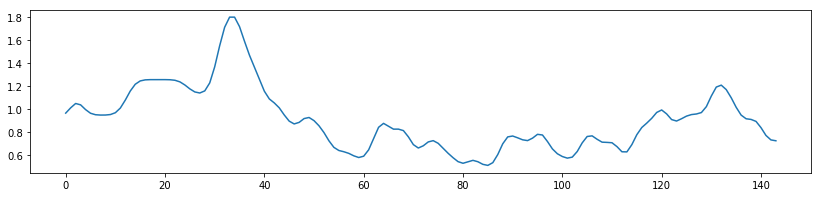

In [89]:
plt.figure(figsize=(14, 3))
plt.plot(dset[1])
plt.show(); plt.close()